# Neural Hamiltonian ODEs
Where we define a perturbation to the hamiltonian mechanics parametrized by a FFNN. This is different, but also obviously connected, from what was briefly studied in the paper:

*Greydanus, S., Dzamba, M., & Yosinski, J.* (2019). Hamiltonian Neural Networks. Advances in neural information processing systems, 32.

in that only the perturbation of the Hamiltonian is parametrized by a network. Let us consider the same system as [in the previous example](./NeuralODEs.ipynb), but this time using the Hamiltonian formalism. We will shortly summarize, in what follows, the obvious as to show later how to obtain the same symbolically and using *heyoka*.

Let us first introduce our Lagrangian coordinates $\mathbf q = [x, y]$ and their derivatives: $\dot{\mathbf q} = [v_x, v_y]$. Under this choice we may compute the kinetic energy of the system as:

$$
T = \frac 12 (v_x^2 + v_y^2)
$$

its potential energy as:

$$
U = \frac 12 k_x x^2 + \frac 12 k_y y^2
$$

and thus its Lagrangian as:

$$
\left(\mathbf q, \dot{\mathbf q}\right) = T - U
$$

We can then compute the trivial *canonical momenta* $\mathbf p=[p_x, p_y]$ as:

$$
\begin{array}{l}
p_x = \frac{\partial {\mathcal L}}{\partial v_x} = v_x \\
p_y = \frac{\partial {\mathcal L}}{\partial v_y} = v_y \\
\end{array}
$$

And the Hamiltonian as:

$$
\mathcal H = \sum_{i=1}^2 p_i \dot q_i - \mathcal L = T + U
$$

... a complicated, albeit very generic, way to show that the system energy is the Hamiltonian!

In [1]:
# The usual main imports
import heyoka as hy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
x, y, px, py = hy.make_vars("x","y","px","py")
H = 0.5 * px**2 + 0.5 * py**2 + 0.5 * hy.par[0] * x**2 + 0.5 * hy.par[1] * y**2

Now, let us define a perturbation to this Hamiltonian, one parametrised by a FFNN:

$$
\mathcal H_\theta(\mathbf p, \mathbf q) = \mathcal H + \epsilon \mathcal N_\theta(\mathbf p, \mathbf q)
$$

In [3]:
# Network parameters (play around)
nn_hidden = [10, 10]
activations = [hy.tanh, hy.tanh, hy.tanh] # the output will be in [-1,1]
n_inputs = 4
n_outputs = 1
nn_layers = [n_inputs] + nn_hidden + [n_outputs]

# Weight matrices
Ws = []
for i in range(0, len(activations)):
    Ws.append(0.5 - np.random.random((nn_layers[i], nn_layers[i+1])))
# Bias vectors
bs = []
for i in range(0, len(activations)):
    bs.append(np.random.random((nn_layers[i+1],1)))
# Flatten everything
flattened_nw =  np.concatenate([it.flatten() for it in Ws] + [it.flatten() for it in bs])

# Calling the ffnn factory
ffnn = hy.model.ffnn(inputs = [x, y, px, py], nn_hidden = nn_hidden, n_out = n_outputs, activations = activations, nn_wb = flattened_nw)

# Perturbing the Hamiltonian
H = H + hy.par[2] * ffnn[0]

And we may now compute the equations of motion:

$$
\begin{array}{l}
\dot{\mathbf q} = \frac{\partial \mathcal H}{\partial\mathbf p} \\
\dot{\mathbf p} = - \frac{\partial \mathcal H}{\partial\mathbf q}
\end{array}
$$



In [4]:
dynamics = [(x, hy.diff(H, px)), (y, hy.diff(H, py)), (px, -hy.diff(H, x)), (py, -hy.diff(H, y))]

And define our numerical integrator ... guess ... yes a Taylor integration scheme!

In [5]:
taH = hy.taylor_adaptive(
    # The ODEs.
    dynamics,
    # The initial conditions.
    [0., 1., 1., 0.],
    tol = 1e-16,
    compact_mode = True
)

In [6]:
taH.state[:] = [0., 1., 1., 0.]
taH.time = 0
taH.pars[:] = [1,1,0.0]
tgrid = np.linspace(0,40,1000)
sol = taH.propagate_grid(tgrid)

In [7]:
taH.state[:] = [0., 1., 1., 0.]
taH.time = 0
taH.pars[:] = [1,1,5.3]
tgrid = np.linspace(0,40,1000)
sol_pert = taH.propagate_grid(tgrid)

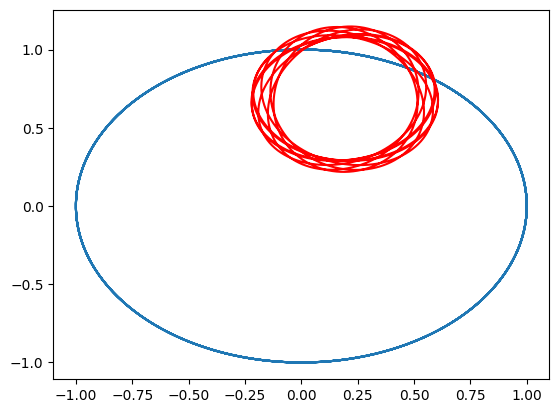

In [8]:
plt.plot(sol[4][:,0], sol[4][:,1])
plt.plot(sol_pert[4][:,0], sol_pert[4][:,1], 'r')

Clearly, the power and interest of this technique, applied to Hamiltonian systems, lies in the possibility to define some good training for the FFNN weights and biases so that the final system converges to something useful 


... and that IS all!